In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, DataFrameIterator
from keras.preprocessing.image import DirectoryIterator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score

In [51]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [3]:
from tqdm import tqdm

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
#!pip install openpyxl

### Data Pre Processing

In [6]:
# Import the metadata
metadata_df = pd.read_excel('Labeling Checklist.xlsx')

# Create a metadata df with only images from the Folders of interest    
metadata_df = metadata_df[metadata_df['Folder'].astype(str).isin(['328', '329', '330', '331', '332', '333', '334',
                                                      '335', '336', '337', '338', '339', '340', '342',
                                                      '343'])]

# Replace labels that start with "DUPLICATE OF" with NaN. Drop rows with NaN for labels
metadata_df['CATEGORY 1'] = np.where(metadata_df['CATEGORY 1'].str.upper().str.startswith('DUPLICATE'), np.nan, metadata_df['CATEGORY 1'])
metadata_df.dropna(subset=['CATEGORY 1'], inplace=True)

# Add a new column that combines Folder and File name (will be unique for each entry)
metadata_df['ext'] = metadata_df['Folder'].astype(str) + '/' + metadata_df['File']

#Create multilabels column
metadata_df['labels'] = metadata_df[['CATEGORY 1', 'CATEGORY 2', 'CATEGORY 3']].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)

#Drop unused columns
columns_to_drop = ['id', 'manifestid', 'documentid', 'Full', 'uploaddatetimejsonmetadata', 'Folder', 'File', 'LABEL', 'SIGN OUT', 'ALLIGATOR', 'NOTES', 'onpremfilepathjsonmetadata']
metadata_df.drop(columns=columns_to_drop, inplace=True)

metadata_df.head()

CATEGORY 1 CATEGORY 2 CATEGORY 3  POOR QUALITY            ext   labels
0       pass        NaN        NaN           0.0  328/644-0.jpg     pass
1    dunnage        NaN        NaN           0.0  328/656-0.jpg  dunnage
2       pass        NaN        NaN           0.0  328/720-0.jpg     pass
3     airbag        NaN        NaN           0.0  328/779-0.jpg   airbag
4       pass        NaN        NaN           0.0  328/780-0.jpg     pass

In [7]:
#Drop column categories, and poor quality as we already have labels
columns_to_drop = ['CATEGORY 1', 'CATEGORY 2', 'CATEGORY 3', 'POOR QUALITY']
metadata_df.drop(columns=columns_to_drop, inplace=True)
metadata_df.head()

ext   labels
0  328/644-0.jpg     pass
1  328/656-0.jpg  dunnage
2  328/720-0.jpg     pass
3  328/779-0.jpg   airbag
4  328/780-0.jpg     pass

In [8]:
labels = metadata_df['labels']

# Split the labels column by comma, convert to lowercase, and strip whitespace
labels_split = labels.str.lower().str.split(',\s*')

# Create a DataFrame with one-hot encoded labels
one_hot_labels = labels_split.apply(lambda x: pd.Series(1, index=x)).fillna(0)

# Concatenate the original DataFrame with the one-hot encoded labels
modified_df = pd.concat([metadata_df[['labels', 'ext']], one_hot_labels], axis=1)
modified_df.head(20)

labels            ext  pass  dunnage  airbag   
0                      pass  328/644-0.jpg   1.0      0.0     0.0  \
1                   dunnage  328/656-0.jpg   0.0      1.0     0.0   
2                      pass  328/720-0.jpg   1.0      0.0     0.0   
3                    airbag  328/779-0.jpg   0.0      0.0     1.0   
4                      pass  328/780-0.jpg   1.0      0.0     0.0   
5                      pass  328/781-0.jpg   1.0      0.0     0.0   
6                    airbag  328/782-0.jpg   0.0      0.0     1.0   
7           return to level  328/783-0.jpg   0.0      0.0     0.0   
8                      pass  328/784-0.jpg   1.0      0.0     0.0   
9                     strap  328/786-0.jpg   0.0      0.0     0.0   
10                     pass  328/844-0.jpg   1.0      0.0     0.0   
11                     pass  328/845-0.jpg   1.0      0.0     0.0   
12                     pass  328/846-0.jpg   1.0      0.0     0.0   
13                     pass  328/847-0.jpg   1.0      0.0     0.0   
14                  dunnage  328/848-0.jpg   0.0      1.0     0.0   
15                     pass  328/849-0.jpg   1.0      0.0     0.0   
16                     pass  328/850-0.jpg   1.0      0.0     0.0   
18          return to level  328/852-0.jpg   0.0      0.0     0.0   
19  return to level, airbag  328/868-0.jpg   0.0      0.0     1.0   
20                   airbag  328/869-0.jpg   0.0      0.0     1.0   

    return to level  strap  restack  
0               0.0    0.0      0.0  
1               0.0    0.0      0.0  
2               0.0    0.0      0.0  
3               0.0    0.0      0.0  
4               0.0    0.0      0.0  
5               0.0    0.0      0.0  
6               0.0    0.0      0.0  
7               1.0    0.0      0.0  
8               0.0    0.0      0.0  
9               0.0    1.0      0.0  
10              0.0    0.0      0.0  
11              0.0    0.0      0.0  
12              0.0    0.0      0.0  
13              0.0    0.0      0.0  
14              0.0    0.0      0.0  
15              0.0    0.0      0.0  
16              0.0    0.0      0.0  
18              1.0    0.0      0.0  
19              1.0    0.0      0.0  
20              0.0    0.0      0.0

In [9]:
#Load the images
train_image = []
for path in tqdm(modified_df["ext"]):
    img = Image.open('Labeled/' + path).convert('RGB')
    img = img.resize((400, 400))
    img = np.array(img) / 255.0
    train_image.append(img)

X = np.array(train_image)


100%|█████████████████████████████████████████| 560/560 [00:24<00:00, 22.42it/s]


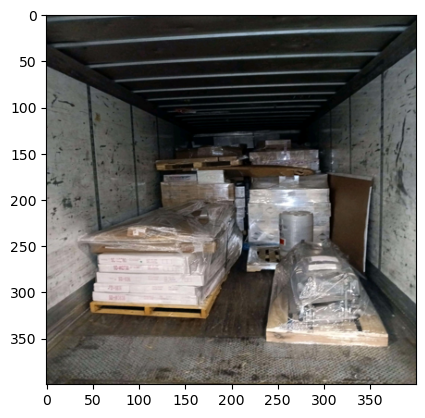

In [10]:
#Check the images
plt.imshow(X[3])

In [11]:
modified_df['labels'][3]

'airbag'

In [12]:
X.shape

(560, 400, 400, 3)

In [13]:
y = np.array(modified_df.drop(['labels', 'ext'], axis=1))
y.shape

(560, 6)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

### Modeling

In [15]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400, 400, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

Metal device set to: Apple M1


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 396, 396, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 198, 198, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 198, 198, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 194, 194, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 97, 97, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 97, 97, 32)        0

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/10


2023-05-20 14:27:02.222600: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 12s 1s/step - loss: 0.6641 - accuracy: 0.2937 - val_loss: 0.5621 - val_accuracy: 0.3750
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 0.5143 - accuracy: 0.4107 - val_loss: 0.5466 - val_accuracy: 0.3750
Epoch 3/10
8/8 [==============================] - 8s 1s/step - loss: 0.4847 - accuracy: 0.3889 - val_loss: 0.5636 - val_accuracy: 0.3750
Epoch 4/10
8/8 [==============================] - 8s 1s/step - loss: 0.4618 - accuracy: 0.4147 - val_loss: 0.5219 - val_accuracy: 0.3750
Epoch 5/10
8/8 [==============================] - 8s 1s/step - loss: 0.4475 - accuracy: 0.4246 - val_loss: 0.4838 - val_accuracy: 0.3750
Epoch 6/10
8/8 [==============================] - 8s 1s/step - loss: 0.4421 - accuracy: 0.4246 - val_loss: 0.4825 - val_accuracy: 0.3750
Epoch 7/10
8/8 [==============================] - 8s 1s/step - loss: 0.4364 - accuracy: 0.4246 - val_loss: 0.4933 - val_accuracy: 0.3750
Epoch 8/10
8/8 [==============================] - 

In [19]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

2/2 [==============================] - 0s 127ms/step - loss: 0.4682 - accuracy: 0.3750
Test accuracy: 0.375
Test loss: 0.4681609570980072


In [20]:
#Predict on test data
predictions = model.predict(X_test)

# The predictions will be in the form of probabilities for each class
threshold = 0.3  # Adjust the threshold as per requirement

binary_predictions = (predictions > threshold).astype(int)

2/2 [==============================] - 0s 152ms/step


Sample 1
Predicted labels: [1 0 1 0 0 0]


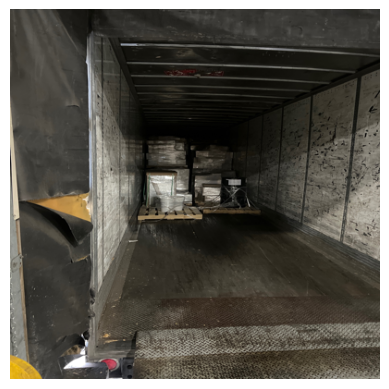

Sample 2
Predicted labels: [1 0 1 0 0 0]


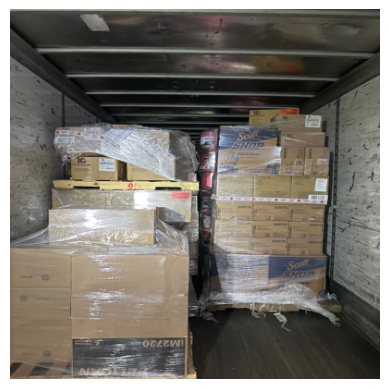

Sample 3
Predicted labels: [1 0 1 0 0 0]


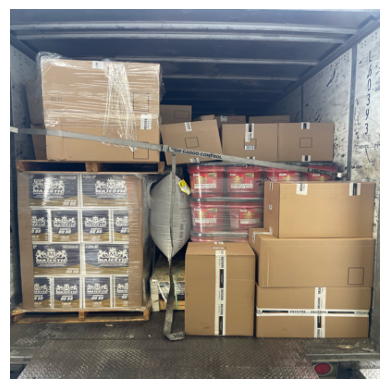

Sample 4
Predicted labels: [1 0 1 0 0 0]


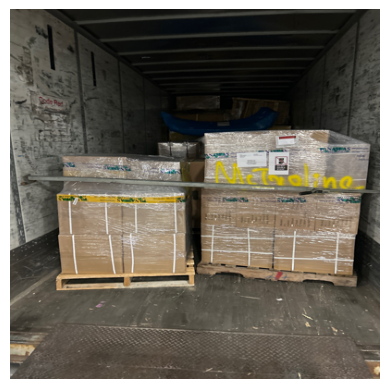

Sample 5
Predicted labels: [1 0 1 0 0 0]


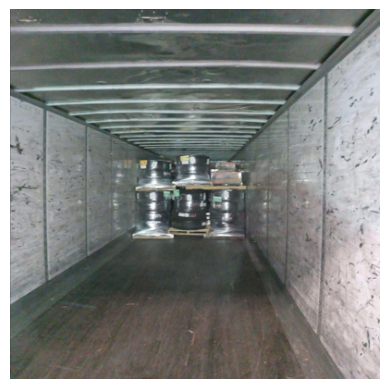

In [21]:
import matplotlib.pyplot as plt

# Print the predicted labels and corresponding images
for i in range(5):
    print("Sample", i+1)
    print("Predicted labels:", binary_predictions[i])
    
    # Plot the corresponding image
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.show()

The results look confusing because there are samples predicted as pass but also categorized in other like airbag category. So next I'll try to use binary classification first to classify good and bad trailer, and then within the bad loaded trailers, I'll try again the multilabel classification

## Binary and Multilabel image classification

#### Binary Classification to separate good and bad loaded trailer

In [22]:
# Import the metadata
metadata_df = pd.read_excel('Labeling Checklist.xlsx')

# Create a metadata df with only images from the Folders of interest    
metadata_df = metadata_df[metadata_df['Folder'].astype(str).isin(['328', '329', '330', '331', '332', '333', '334',
                                                      '335', '336', '337', '338', '339', '340', '342',
                                                      '343'])]

# Replace labels that start with "DUPLICATE OF" with NaN. Drop rows with NaN for labels
metadata_df['CATEGORY 1'] = np.where(metadata_df['CATEGORY 1'].str.upper().str.startswith('DUPLICATE'), np.nan, metadata_df['CATEGORY 1'])
metadata_df.dropna(subset=['CATEGORY 1'], inplace=True)

# Add a new column that combines Folder and File name (will be unique for each entry)
metadata_df['ext'] = metadata_df['Folder'].astype(str) + '/' + metadata_df['File']

#Create labels column
metadata_df['labels'] = 'bad'
mask = metadata_df['CATEGORY 1'].str.lower().isin(['pass'])
metadata_df.loc[mask, 'labels'] = 'good'

#Drop unused columns
columns_to_drop = ['id', 'manifestid', 'documentid', 'Full', 'uploaddatetimejsonmetadata', 'Folder', 'File', 'LABEL', 'SIGN OUT', 'ALLIGATOR', 'NOTES', 'onpremfilepathjsonmetadata']
metadata_df.drop(columns=columns_to_drop, inplace=True)

metadata_df.head()


CATEGORY 1 CATEGORY 2 CATEGORY 3  POOR QUALITY            ext labels
0       pass        NaN        NaN           0.0  328/644-0.jpg   good
1    dunnage        NaN        NaN           0.0  328/656-0.jpg    bad
2       pass        NaN        NaN           0.0  328/720-0.jpg   good
3     airbag        NaN        NaN           0.0  328/779-0.jpg    bad
4       pass        NaN        NaN           0.0  328/780-0.jpg   good

In [23]:
columns_to_drop = ['CATEGORY 1', 'CATEGORY 2', 'CATEGORY 3', 'POOR QUALITY']
metadata_df.drop(columns=columns_to_drop, inplace=True)

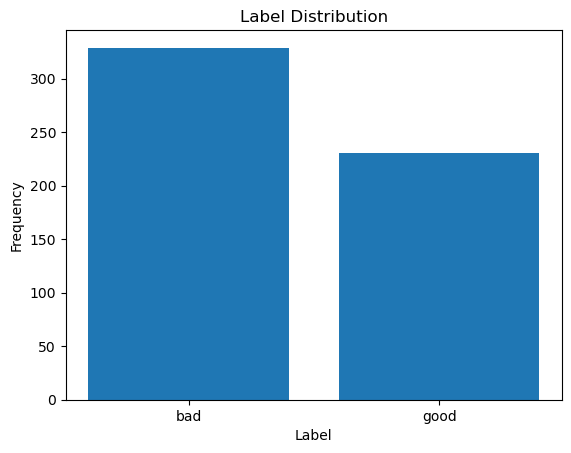

In [24]:
# Re-define labels
labels = metadata_df['labels'].tolist()

# Find the unique labels and their frequency in the dataset.
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Create a bar plot of the label distribution.
plt.bar(unique_labels, label_counts)

# Set the plot title and axis labels.
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")

# Show the plot.
plt.show()

In [25]:
#Load the images
train_image = []
for path in tqdm(metadata_df["ext"]):
    img = Image.open('Labeled/' + path).convert('RGB')
    img = img.resize((400, 400))
    img = np.array(img) / 255.0
    train_image.append(img)

X = np.array(train_image)

100%|█████████████████████████████████████████| 560/560 [00:24<00:00, 22.46it/s]


good


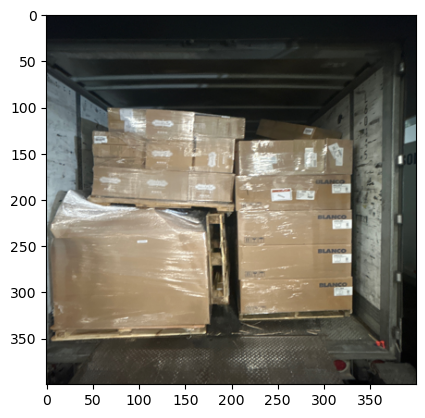

In [31]:
print(metadata_df['labels'][4])
plt.imshow(X[4])

In [32]:
X.shape

(560, 400, 400, 3)

In [52]:
y = np.array(metadata_df.drop(['ext'], axis=1))

y.shape

(560, 1)

In [53]:
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)

/Users/nidaulhaq/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nidaulhaq/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [55]:
y_encoded.shape

(560,)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=42, test_size=0.1)

Binary classification model

In [59]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400, 400, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 396, 396, 16)      1216      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 198, 198, 16)     0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 198, 198, 16)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 194, 194, 32)      12832     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 97, 97, 32)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 97, 97, 32)       

In [60]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/10
8/8 [==============================] - 14s 1s/step - loss: 0.7591 - accuracy: 0.5615 - val_loss: 0.6859 - val_accuracy: 0.6071
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 0.6871 - accuracy: 0.5774 - val_loss: 0.6902 - val_accuracy: 0.6071
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 0.6848 - accuracy: 0.5853 - val_loss: 0.6818 - val_accuracy: 0.6071
Epoch 4/10
8/8 [==============================] - 9s 1s/step - loss: 0.6832 - accuracy: 0.5833 - val_loss: 0.6782 - val_accuracy: 0.6071
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 0.6840 - accuracy: 0.5853 - val_loss: 0.6806 - val_accuracy: 0.6071
Epoch 6/10
8/8 [==============================] - 9s 1s/step - loss: 0.6817 - accuracy: 0.5853 - val_loss: 0.6741 - val_accuracy: 0.6071
Epoch 7/10
8/8 [==============================] - 9s 1s/step - loss: 0.6807 - accuracy: 0.5853 - val_loss: 0.6743 - val_accuracy: 0.6071
Epoch 8/10
8/8 [=====================

In [61]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

2/2 [==============================] - 0s 140ms/step - loss: 0.6750 - accuracy: 0.6071
Test accuracy: 0.6071428656578064
Test loss: 0.675024688243866


In [81]:
print(np.max(predictions))
print(np.min(predictions))

0.44308466
0.44208464


In [82]:
#Predict on test data
predictions = model.predict(X_test)

# The predictions will be in the form of probabilities for each class
threshold = 0.4425  # Adjust the threshold as per requirement

binary_predictions = (predictions > threshold).astype(int)

2/2 [==============================] - 0s 135ms/step


In [83]:
np.unique(binary_predictions)

array([0, 1])

Good trailer = 1, bad trailer = 0

Sample 1
Predicted labels: [1]


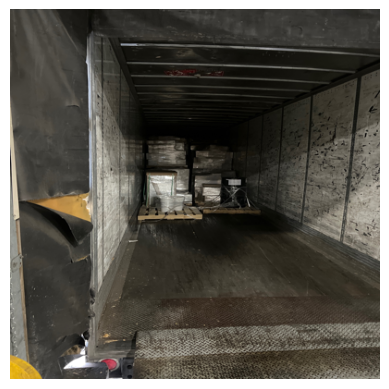

Sample 2
Predicted labels: [1]


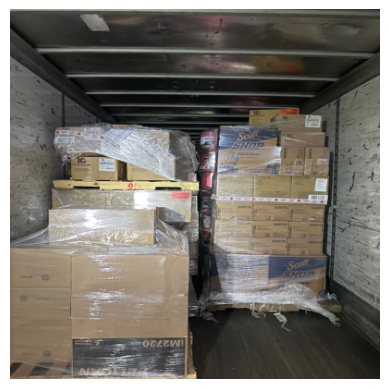

Sample 3
Predicted labels: [1]


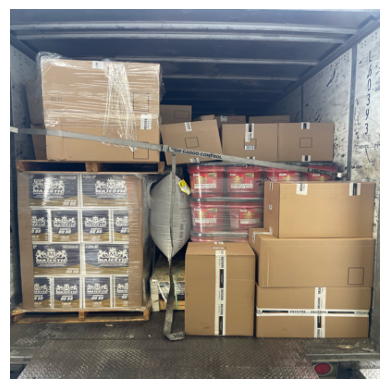

Sample 4
Predicted labels: [1]


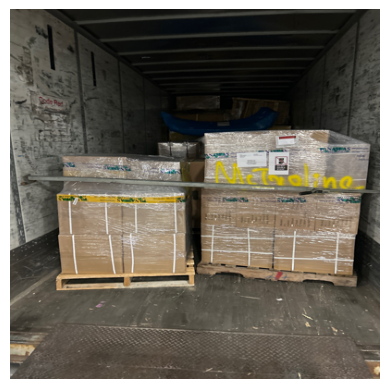

Sample 5
Predicted labels: [1]


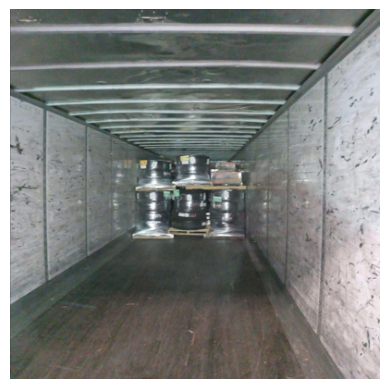

In [84]:
import matplotlib.pyplot as plt

# Print the predicted labels and corresponding images
for i in range(5):
    print("Sample", i+1)
    print("Predicted labels:", binary_predictions[i])
    
    # Plot the corresponding image
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.show()

### Multilabel classification only for bad loaded trailers

In [87]:
# Import the metadata
metadata_df = pd.read_excel('Labeling Checklist.xlsx')

# Create a metadata df with only images from the Folders of interest    
metadata_df = metadata_df[metadata_df['Folder'].astype(str).isin(['328', '329', '330', '331', '332', '333', '334',
                                                      '335', '336', '337', '338', '339', '340', '342',
                                                      '343'])]

# Replace labels that start with "DUPLICATE OF" with NaN. Drop rows with NaN for labels
metadata_df['CATEGORY 1'] = np.where(metadata_df['CATEGORY 1'].str.upper().str.startswith('DUPLICATE'), np.nan, metadata_df['CATEGORY 1'])
metadata_df.dropna(subset=['CATEGORY 1'], inplace=True)

#Drop rows with pass label (good loaded trailer)
metadata_df = metadata_df[~metadata_df['CATEGORY 1'].str.contains('pass', case=False)]

# Add a new column that combines Folder and File name (will be unique for each entry)
metadata_df['ext'] = metadata_df['Folder'].astype(str) + '/' + metadata_df['File']

#Create multilabels column
metadata_df['labels'] = metadata_df[['CATEGORY 1', 'CATEGORY 2', 'CATEGORY 3']].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)

#Drop unused columns
columns_to_drop = ['id', 'manifestid', 'documentid', 'Full', 'uploaddatetimejsonmetadata', 'Folder', 'File', 'LABEL', 'SIGN OUT', 'ALLIGATOR', 'NOTES', 'onpremfilepathjsonmetadata']
metadata_df.drop(columns=columns_to_drop, inplace=True)

metadata_df.head()

CATEGORY 1 CATEGORY 2 CATEGORY 3  POOR QUALITY            ext   
1          dunnage        NaN        NaN           0.0  328/656-0.jpg  \
3           airbag        NaN        NaN           0.0  328/779-0.jpg   
6           airbag        NaN        NaN           0.0  328/782-0.jpg   
7  return to level        NaN        NaN           0.0  328/783-0.jpg   
9            strap        NaN        NaN           0.0  328/786-0.jpg   

            labels  
1          dunnage  
3           airbag  
6           airbag  
7  return to level  
9            strap

In [88]:
#Drop column categories, and poor quality as we already have labels
columns_to_drop = ['CATEGORY 1', 'CATEGORY 2', 'CATEGORY 3', 'POOR QUALITY']
metadata_df.drop(columns=columns_to_drop, inplace=True)
metadata_df.head()

ext           labels
1  328/656-0.jpg          dunnage
3  328/779-0.jpg           airbag
6  328/782-0.jpg           airbag
7  328/783-0.jpg  return to level
9  328/786-0.jpg            strap

In [89]:
metadata_df.shape

(329, 2)

In [90]:
labels = metadata_df['labels']

# Split the labels column by comma, convert to lowercase, and strip whitespace
labels_split = labels.str.lower().str.split(',\s*')

# Create a DataFrame with one-hot encoded labels
one_hot_labels = labels_split.apply(lambda x: pd.Series(1, index=x)).fillna(0)

# Concatenate the original DataFrame with the one-hot encoded labels
modified_df = pd.concat([metadata_df[['labels', 'ext']], one_hot_labels], axis=1)
modified_df.head(20)

labels            ext  dunnage  airbag  return to level   
1                   dunnage  328/656-0.jpg      1.0     0.0              0.0  \
3                    airbag  328/779-0.jpg      0.0     1.0              0.0   
6                    airbag  328/782-0.jpg      0.0     1.0              0.0   
7           return to level  328/783-0.jpg      0.0     0.0              1.0   
9                     strap  328/786-0.jpg      0.0     0.0              0.0   
14                  dunnage  328/848-0.jpg      1.0     0.0              0.0   
18          return to level  328/852-0.jpg      0.0     0.0              1.0   
19  return to level, airbag  328/868-0.jpg      0.0     1.0              1.0   
20                   airbag  328/869-0.jpg      0.0     1.0              0.0   
22  return to level, airbag  328/892-0.jpg      0.0     1.0              1.0   
27          return to level  328/901-0.jpg      0.0     0.0              1.0   
28                   airbag  328/902-0.jpg      0.0     1.0              0.0   
32                   airbag  328/921-0.jpg      0.0     1.0              0.0   
33          dunnage, airbag  328/922-0.jpg      1.0     1.0              0.0   
35                   airbag  328/924-0.jpg      0.0     1.0              0.0   
39                   airbag  328/932-0.jpg      0.0     1.0              0.0   
41                   airbag  328/970-0.jpg      0.0     1.0              0.0   
45          return to level  328/974-0.jpg      0.0     0.0              1.0   
46            airbag, strap  328/975-0.jpg      0.0     1.0              0.0   
49                   airbag  328/978-0.jpg      0.0     1.0              0.0   

    strap  restack  
1     0.0      0.0  
3     0.0      0.0  
6     0.0      0.0  
7     0.0      0.0  
9     1.0      0.0  
14    0.0      0.0  
18    0.0      0.0  
19    0.0      0.0  
20    0.0      0.0  
22    0.0      0.0  
27    0.0      0.0  
28    0.0      0.0  
32    0.0      0.0  
33    0.0      0.0  
35    0.0      0.0  
39    0.0      0.0  
41    0.0      0.0  
45    0.0      0.0  
46    1.0      0.0  
49    0.0      0.0

In [91]:
#Load the images
train_image = []
for path in tqdm(modified_df["ext"]):
    img = Image.open('Labeled/' + path).convert('RGB')
    img = img.resize((400, 400))
    img = np.array(img) / 255.0
    train_image.append(img)

X = np.array(train_image)

100%|█████████████████████████████████████████| 329/329 [00:14<00:00, 22.17it/s]


In [92]:
y = np.array(modified_df.drop(['labels', 'ext'], axis=1))

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [94]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400, 400, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 396, 396, 16)      1216      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 198, 198, 16)     0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 198, 198, 16)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 194, 194, 32)      12832     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 97, 97, 32)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 97, 97, 32)       

In [95]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/10
5/5 [==============================] - 9s 2s/step - loss: 0.6188 - accuracy: 0.4865 - val_loss: 0.6108 - val_accuracy: 0.5455
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 0.4833 - accuracy: 0.7264 - val_loss: 0.5780 - val_accuracy: 0.5455
Epoch 3/10
5/5 [==============================] - 5s 1s/step - loss: 0.4755 - accuracy: 0.7399 - val_loss: 0.5818 - val_accuracy: 0.5455
Epoch 4/10
5/5 [==============================] - 5s 1s/step - loss: 0.4695 - accuracy: 0.7365 - val_loss: 0.5309 - val_accuracy: 0.5455
Epoch 5/10
5/5 [==============================] - 5s 983ms/step - loss: 0.4630 - accuracy: 0.7466 - val_loss: 0.5463 - val_accuracy: 0.5455
Epoch 6/10
5/5 [==============================] - 5s 988ms/step - loss: 0.4470 - accuracy: 0.7466 - val_loss: 0.5188 - val_accuracy: 0.5455
Epoch 7/10
5/5 [==============================] - 5s 1s/step - loss: 0.4361 - accuracy: 0.7466 - val_loss: 0.5217 - val_accuracy: 0.5455
Epoch 8/10
5/5 [===================

In [96]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

2/2 [==============================] - 1s 601ms/step - loss: 0.5156 - accuracy: 0.5455
Test accuracy: 0.5454545617103577
Test loss: 0.5156393051147461


In [97]:
#Predict on test data
predictions = model.predict(X_test)

# The predictions will be in the form of probabilities for each class
threshold = 0.3  # Adjust the threshold as per requirement

binary_predictions = (predictions > threshold).astype(int)

2/2 [==============================] - 0s 177ms/step


Sample 6
Predicted labels: [0 1 0 0 0]


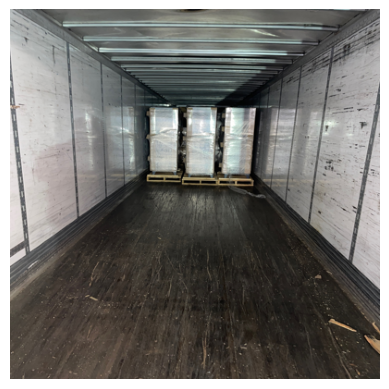

Sample 7
Predicted labels: [0 1 0 0 0]


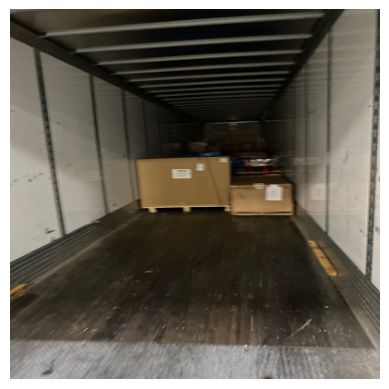

Sample 8
Predicted labels: [0 1 0 0 0]


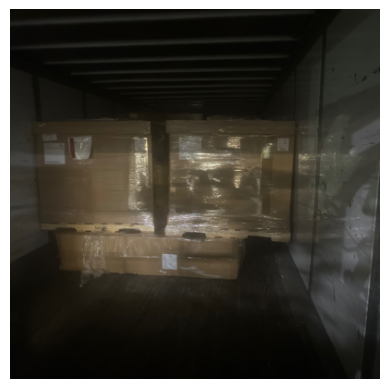

Sample 9
Predicted labels: [0 1 0 0 0]


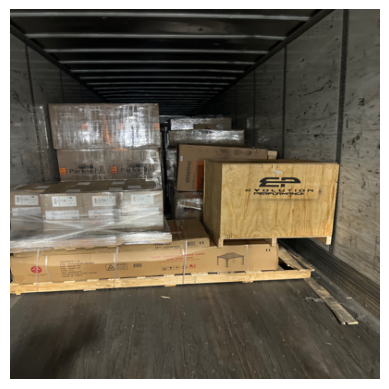

Sample 10
Predicted labels: [0 1 0 0 0]


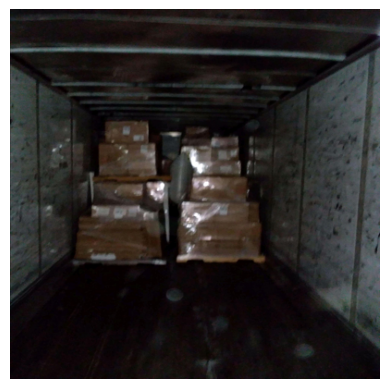

In [99]:
import matplotlib.pyplot as plt

# Print the predicted labels and corresponding images
for i in range(5,10):
    print("Sample", i+1)
    print("Predicted labels:", binary_predictions[i])
    
    # Plot the corresponding image
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.show()